## Disease Condition prediction based on drug reviews

## Importing libraries

In [ ]:
import pandas as pd # data preprocessing
import itertools # confusion matrix
import string
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
# To show all the rows of pandas dataframe
pd.set_option('display.max_rows', None)

In [1]:
import nltk
import sklearn
import bs4
print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The scikit-learn version is {}.'.format(bs4.__version__))

The nltk version is 3.8.1.
The scikit-learn version is 1.6.1.
The scikit-learn version is 4.12.3.


In [3]:
import pandas as pd
df=pd.read_csv('data/drugsComTrain_raw.tsv', sep='\t')

In [4]:
df.to_csv('data/drugsComTrain.csv',index=False)

In [5]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [6]:
df.condition.value_counts()

condition
Birth Control                                              28788
Depression                                                  9069
Pain                                                        6145
Anxiety                                                     5904
Acne                                                        5588
                                                           ...  
Dissociative Identity Disorde                                  1
Hydrocephalus                                                  1
Hyperlipoproteinemia Type III, Elevated beta-VLDL   IDL        1
Q Feve                                                         1
Neutropenia                                                    1
Name: count, Length: 884, dtype: int64

In [ ]:
#Filtering Data for Specific Conditions
df_train = df[(df['condition']=='Birth Control') | (df['condition']=='Depression')  | (df['condition']=='Pain') | (df['condition']=='Bipolar Disorde') | (df['condition']=='ADHD') | (df['condition']=='Anxiety') | (df['condition']=='High Blood Pressure')|(df['condition']=='Diabetes, Type 2')]

In [8]:
df.shape

(161297, 7)

In [9]:
df_train.shape

(62388, 7)

In [10]:
X = df_train.drop(['Unnamed: 0','drugName','rating','date','usefulCount'],axis=1)

## EDA

In [11]:
X.condition.value_counts()

condition
Birth Control          28788
Depression              9069
Pain                    6145
Anxiety                 5904
Bipolar Disorde         4224
ADHD                    3383
Diabetes, Type 2        2554
High Blood Pressure     2321
Name: count, dtype: int64

In [12]:
X.head()

,condition,review
1,ADHD,"""My son is halfway through his fourth week of ..."
2,Birth Control,"""I used to take another oral contraceptive, wh..."
3,Birth Control,"""This is my first time using any form of birth..."
7,Bipolar Disorde,"""Abilify changed my life. There is hope. I was..."
9,Birth Control,"""I had been on the pill for many years. When m..."


In [13]:
# segregating dataframe for analyzing individual condition
X_birth=X[(X['condition']=='Birth Control')]
X_dep=X[(X['condition']=='Depression')]
X_bp=X[(X['condition']=='High Blood Pressure')]
X_diab=X[(X['condition']=='Diabetes, Type 2')]

## data preprocessing

In [14]:
X['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

In [15]:
X['review'][11]

'"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."'

In [17]:
X.head()

,condition,review
1,ADHD,My son is halfway through his fourth week of I...
2,Birth Control,"I used to take another oral contraceptive, whi..."
3,Birth Control,This is my first time using any form of birth ...
7,Bipolar Disorde,Abilify changed my life. There is hope. I was ...
9,Birth Control,I had been on the pill for many years. When my...


### What are stopwords ?

Stopwords are the most common words in any natural language. For the purpose of building NLP models, these stopwords might not add much value to the meaning of the document.

The most common words used in a text are **“the”, “is”, “in”, “for”, “where”, “when”, “to”, “at”** etc.

In [18]:
from nltk.corpus import stopwords

stop = stopwords.words('english')


In [19]:
stop

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

## Lemmitization
Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma .

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

#remove suffixes based 
porter = PorterStemmer()

lemmatizer = WordNetLemmatizer()

In [21]:
print(porter.stem("sportingly"))
print(porter.stem("very"))
print(porter.stem("troubled"))

sportingli
veri
troubl


In [22]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rajar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [23]:
print(lemmatizer.lemmatize("sportingly"))
print(lemmatizer.lemmatize("very"))
print(lemmatizer.lemmatize("troubled"))

sportingly
very
troubled


In [24]:
from bs4 import BeautifulSoup
import re

In [25]:
def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stop]
    # 6. lemmitization
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(lemmitize_words))

In [26]:
X['review_clean'] = X['review'].apply(review_to_words)

C:\Users\rajar\AppData\Local\Temp\ipykernel_13472\2066199760.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


In [27]:
X.head()

,condition,review,review_clean
1,ADHD,My son is halfway through his fourth week of I...,son halfway fourth week intuniv became concern...
2,Birth Control,"I used to take another oral contraceptive, whi...",used take another oral contraceptive pill cycl...
3,Birth Control,This is my first time using any form of birth ...,first time using form birth control glad went ...
7,Bipolar Disorde,Abilify changed my life. There is hope. I was ...,abilify changed life hope zoloft clonidine fir...
9,Birth Control,I had been on the pill for many years. When my...,pill many year doctor changed rx chateal effec...


## Creating features and Target Variable

In [28]:
X_feat=X['review_clean']
y=X['condition']

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_feat, y,stratify=y,test_size=0.2, random_state=0)

In [2]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.show()

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Bag of Words

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')

count_train = count_vectorizer.fit_transform(X_train)

count_test = count_vectorizer.transform(X_test)

In [36]:
count_train

<49910x20925 sparse matrix of type '<class 'numpy.int64'>'
	with 1535078 stored elements in Compressed Sparse Row format>

## Machine Learning Model : Passive Aggressive Classifier

Accuracy: 0.905


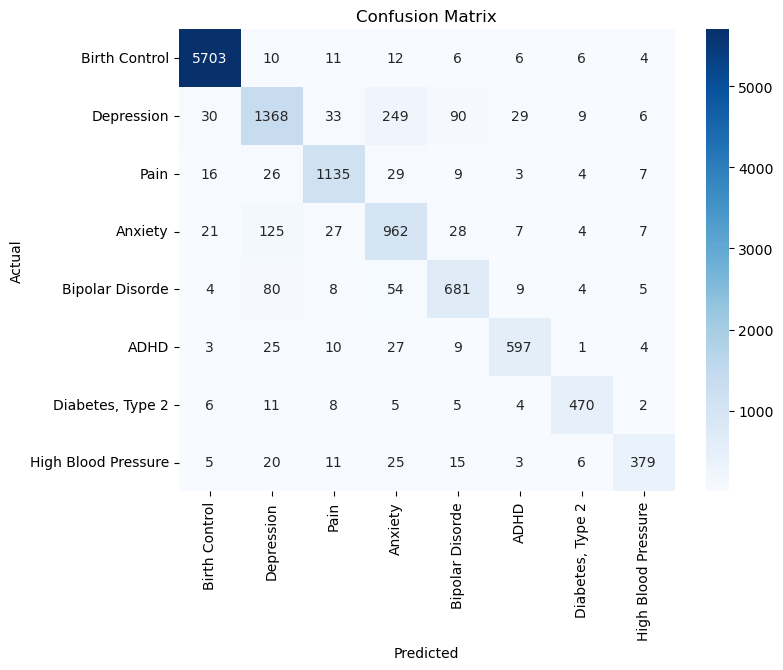

In [40]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Train the classifier
passive = PassiveAggressiveClassifier()
passive.fit(count_train, y_train)

# Make predictions
pred = passive.predict(count_test)

# Calculate accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy: %0.3f" % score)

# Compute confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Pain','Anxiety','Bipolar Disorde','ADHD','Diabetes, Type 2','High Blood Pressure'])

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Birth Control', 'Depression','Pain','Anxiety','Bipolar Disorde','ADHD','Diabetes, Type 2','High Blood Pressure'], 
            yticklabels=['Birth Control', 'Depression','Pain','Anxiety','Bipolar Disorde','ADHD','Diabetes, Type 2','High Blood Pressure'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### TFIDF

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)

## Machine Learning Model TFIDF

Accuracy: 0.916


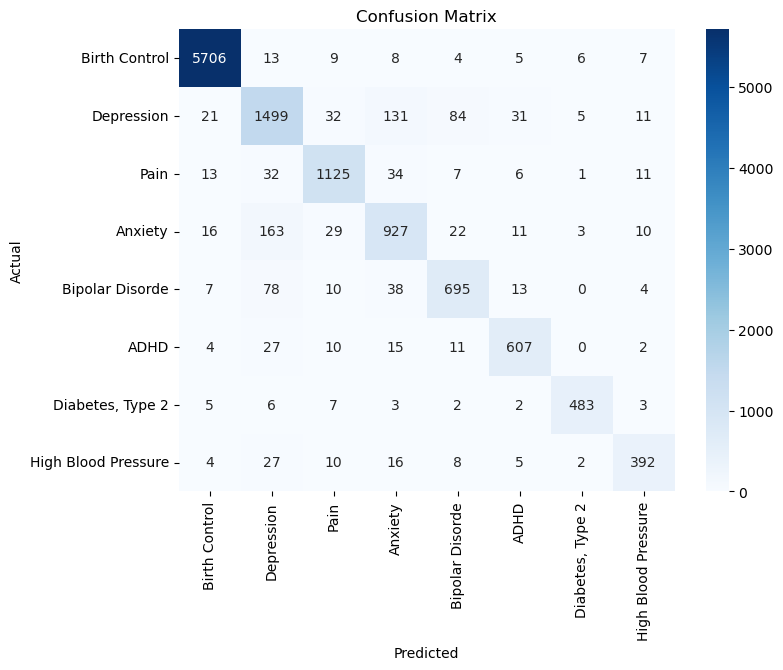

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Vectorize text data
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

# Train the Passive Aggressive Classifier
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train, y_train)

# Make predictions
pred = pass_tf.predict(tfidf_test)

# Calculate accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy: %0.3f" % score)

# Compute confusion matrix
labels = ['Birth Control', 'Depression', 'Pain', 'Anxiety', 'Bipolar Disorde', 'ADHD', 'Diabetes, Type 2', 'High Blood Pressure']
cm = metrics.confusion_matrix(y_test, pred, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## TFIDF: Bigrams

In [44]:
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer2.transform(X_test)

Accuracy: 0.937


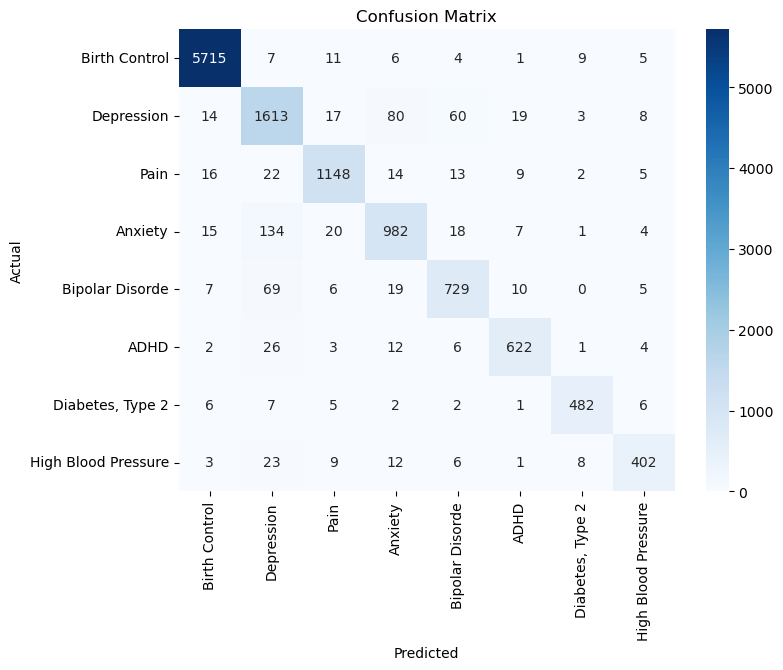

In [46]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Train the Passive Aggressive Classifier
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)

# Make predictions
pred = pass_tf.predict(tfidf_test_2)

# Calculate accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy: %0.3f" % score)

# Compute confusion matrix
labels = ['Birth Control', 'Depression', 'Pain', 'Anxiety', 'Bipolar Disorde', 'ADHD', 'Diabetes, Type 2', 'High Blood Pressure']
cm = metrics.confusion_matrix(y_test, pred, labels=labels)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## TFIDF : Trigrams

Accuracy: 0.939


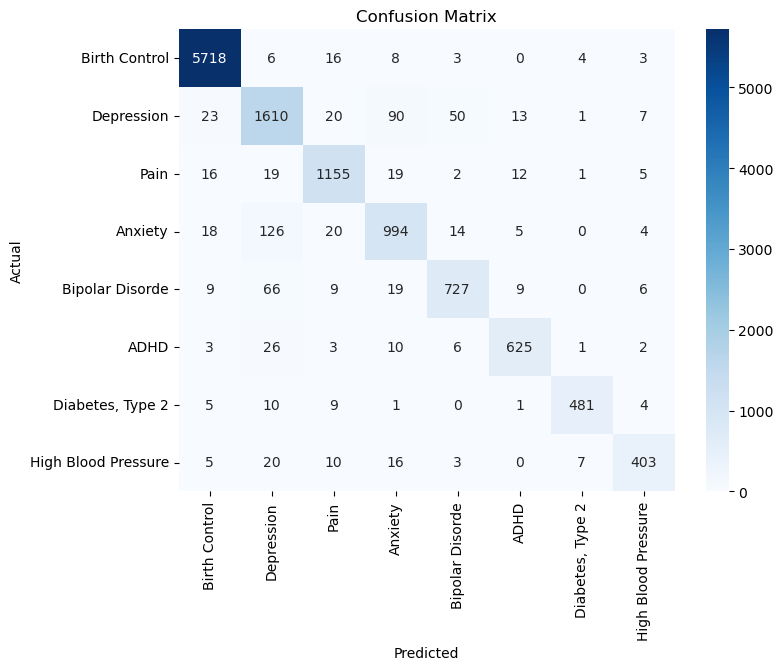

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# TF-IDF Vectorization with n-grams (1,3)
tfidf_vectorizer3 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
tfidf_train_3 = tfidf_vectorizer3.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer3.transform(X_test)

# Train Passive Aggressive Classifier
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_3, y_train)

# Make predictions
pred = pass_tf.predict(tfidf_test_3)

# Calculate accuracy
score = metrics.accuracy_score(y_test, pred)
print("Accuracy: %0.3f" % score)

# Compute confusion matrix
labels = ['Birth Control', 'Depression', 'Pain', 'Anxiety', 'Bipolar Disorde', 'ADHD', 'Diabetes, Type 2', 'High Blood Pressure']
cm = metrics.confusion_matrix(y_test, pred, labels=labels)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Most important Features

In [49]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names_out()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print (classlabel, feat, coef)



most_informative_feature_for_class(tfidf_vectorizer2, pass_tf, 'Birth Control')

Birth Control sleepiness noticed 3.3172998089336994
Birth Control kick habit 4.211012222230601
Birth Control favorite stopped 5.309167539446232
Birth Control little typically 5.55527507966304
Birth Control decision yr 5.803387698777122
Birth Control like deer 6.446130396386882
Birth Control effect anorexia 7.529165784649538
Birth Control drive stopped 7.73620072815385
Birth Control drive roof 8.01967744129424
Birth Control advise beginning 8.618121904144195


In [50]:
most_informative_feature_for_class(tfidf_vectorizer2, pass_tf, 'Depression')

Depression wean cold 2.981413285167493
Depression managed mood 3.135310256269496
Depression nuvaring patch 3.2675096986789782
Depression similar time 3.5955634393097764
Depression normal good 4.123108746880271
Depression heavy far 4.621315744383492
Depression good fibromyalgia 5.766497740988167
Depression bone sinus 6.080340570118933
Depression felt keel 6.337434155474702
Depression nuvaring amazing 11.766861362819565


In [51]:
most_informative_feature_for_class(tfidf_vectorizer2, pass_tf, 'High Blood Pressure')

High Blood Pressure lexapro depressed 2.490646751524033
High Blood Pressure crampa 3.2647885220528186
High Blood Pressure coming scalp 3.264865953647025
High Blood Pressure personal family 3.5854357225143287
High Blood Pressure eng 4.013970034794106
High Blood Pressure food fluid 4.336203932636273
High Blood Pressure difficult reason 4.3810371407695845
High Blood Pressure bit forgetful 4.443396016263653
High Blood Pressure level twice 6.07907093769977
High Blood Pressure extra needle 7.612973761627494


In [52]:
most_informative_feature_for_class(tfidf_vectorizer2, pass_tf, 'Diabetes, Type 2')

Diabetes, Type 2 painless light 2.1697242443304154
Diabetes, Type 2 short overall 2.428518336565371
Diabetes, Type 2 avascular necroses 2.5245077237263205
Diabetes, Type 2 ticked 2.538421658252425
Diabetes, Type 2 time encourage 2.883264753279341
Diabetes, Type 2 amazed high 2.9761233316049664
Diabetes, Type 2 enthusiasm changed 3.3276013088302343
Diabetes, Type 2 pain exertion 4.058256796958472
Diabetes, Type 2 follow hope 4.2920860835373515
Diabetes, Type 2 following normal 4.582726808101745


## Sample Predictions

In [53]:
X.tail()

,condition,review,review_clean
161283,Bipolar Disorde,I was in a very bad place at the time I starte...,bad place time started taking doctor wanted we...
161286,Depression,This is the third med I&#039;ve tried for anxi...,third med tried anxiety mild depression week h...
161287,Anxiety,I was super against taking medication. I&#039;...,super taking medication started dealing anxiet...
161290,High Blood Pressure,I have only been on Tekturna for 9 days. The e...,tekturna day effect immediate also calcium cha...
161291,Birth Control,This would be my second month on Junel. I&#039...,would second month junel birth control year ch...


In [54]:
## Function for Extracting Top drugs

def top_drugs_extractor(condition):
    df_top = df[(df['rating']>=9)&(df['usefulCount']>=100)].sort_values(by = ['rating', 'usefulCount'], ascending = [False, False])
    drug_lst = df_top[df_top['condition']==condition]['drugName'].head(3).tolist()
    return drug_lst

In [55]:
def predict_text(lst_text):
    df_test = pd.DataFrame(lst_text, columns = ['test_sent'])
    df_test["test_sent"] = df_test["test_sent"].apply(review_to_words)
    tfidf_bigram = tfidf_vectorizer3.transform(lst_text)
    prediction = pass_tf.predict(tfidf_bigram)
    df_test['prediction']=prediction
    return df_test

In [56]:
sentences = [
  "I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations.",
    "son halfway fourth week intuniv became concerned began last week started taking highest dose two day could hardly get bed cranky slept nearly hour drive home school vacation unusual called doctor monday morning said stick day see school getting morning last two day problem free much agreeable ever le emotional good thing le cranky remembering thing overall behavior better tried many different medication far effective",
    "I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me",
    
  ]

In [57]:
tfidf_trigram = tfidf_vectorizer3.transform(sentences)


predictions = pass_tf.predict(tfidf_trigram)

for text, label in zip(sentences, predictions):
    if label=="High Blood Pressure":
        target="High Blood Pressure"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Depression":
        target="Depression"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="ADHD":
        target="ADHD"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Diabetes, Type 2":
        target="Diabetes, Type 2"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Bipolar Disorde":
        target="Bipolar Disorde"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Anxiety":
        target="Anxiety"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Pain":
        target="Pain"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    else:
        target="Birth Control"
        print("text:", text, "\Condition:", target)
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()

<>:72: SyntaxWarning: invalid escape sequence '\C'
<>:72: SyntaxWarning: invalid escape sequence '\C'
C:\Users\rajar\AppData\Local\Temp\ipykernel_13472\727699231.py:72: SyntaxWarning: invalid escape sequence '\C'
  print("text:", text, "\Condition:", target)


text: I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations. 
Condition: High Blood Pressure
Top 3 Suggested Drugs:
Losartan
Aldactone
Spironolactone

text: son halfway fourth week intuniv became concerned began last week started taking highest dose two day could hardly get bed cranky slept nearly hour drive home school vacation unusual called doctor monday morning said stick day see school getting morning last two day problem free much agreeable ever le emotional good thing le cranky remembering thing overall behavior better tried many different medication far effective 
Condition: ADHD
Top 3 Suggested Drugs:
Addera

In [58]:
df_testsent = predict_text(sentences)
df_testsent

,test_sent,prediction
0,tekturna day effect immediate also calcium cha...,High Blood Pressure
1,son halfway fourth week intuniv became concern...,ADHD
2,got diagnosed type doctor prescribed invokana ...,"Diabetes, Type 2"


In [59]:
import joblib
joblib.dump(tfidf_vectorizer3, 'tfidfvectorizer.pkl')
joblib.dump(pass_tf, 'passmodel.pkl')

['passmodel.pkl']

In [60]:
vectorizer = joblib.load('tfidfvectorizer.pkl')
model = joblib.load('passmodel.pkl')

test = model.predict(vectorizer.transform(["I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations"]))
test[0]

'High Blood Pressure'